In [1]:
#!pip install opencv-python

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from scipy.ndimage import rotate
import os
import cv2
#from google.colab.patches import cv2_imshow
import warnings
warnings.filterwarnings('ignore')

In [3]:
labels = pd.read_csv("labels.csv")

In [4]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
labels.shape

(10222, 2)

In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [7]:
labels["breed"].nunique()


120

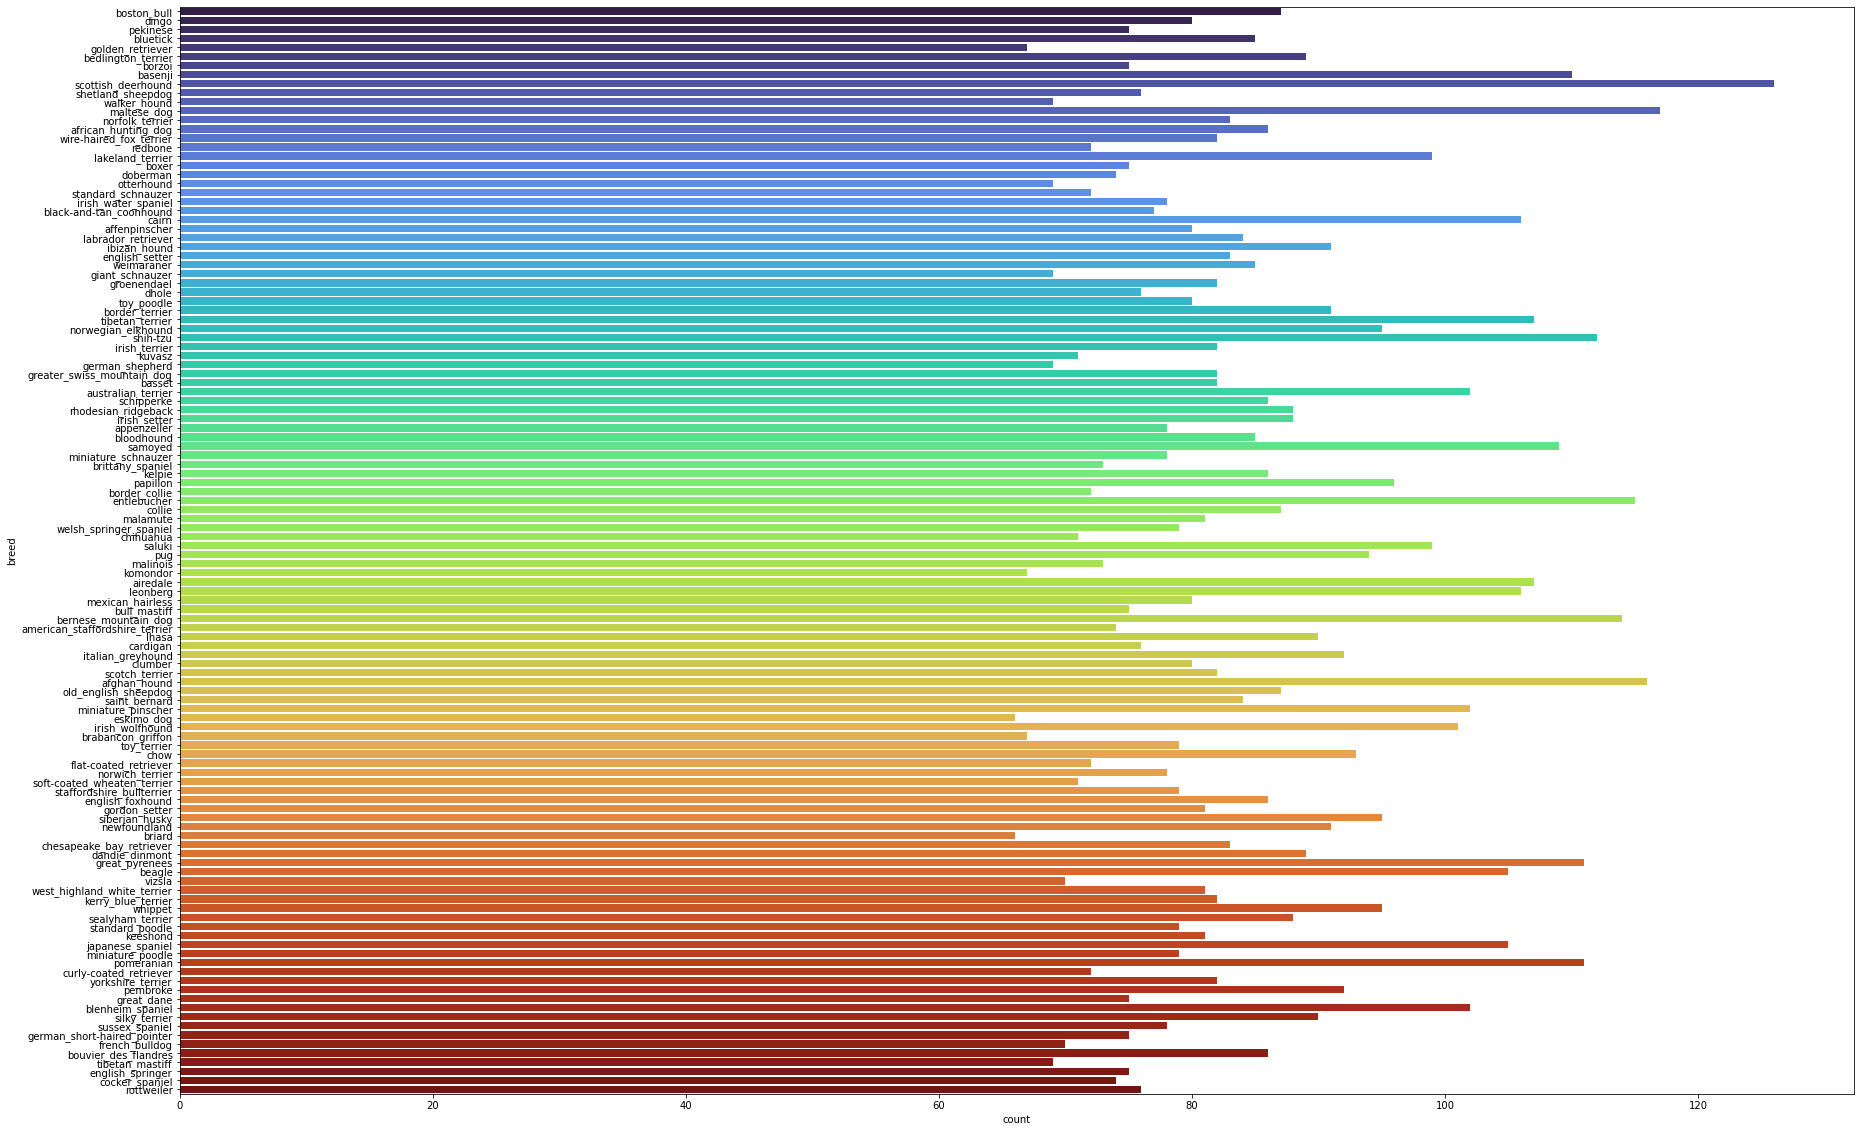

In [8]:
plt.figure(figsize=(30,20))
sns.countplot(y="breed",data=labels,palette="turbo")
plt.show()

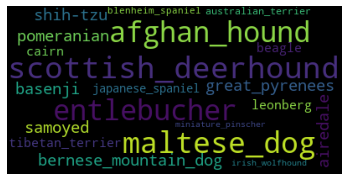

In [9]:
breed_counts = labels["breed"].value_counts()
top_breeds = breed_counts[breed_counts > 100].index.tolist()
labels = labels[labels['breed'].isin(top_breeds)].reset_index(drop=True)

top_breeds_df = pd.DataFrame({'breed': top_breeds})
top_breeds_df['count'] = top_breeds_df['breed'].map(breed_counts)  # 'count' sütununu ekle

from wordcloud import WordCloud
wordcloud = WordCloud(width=400, height=200, background_color='black', min_font_size=7).generate_from_frequencies(top_breeds_df.set_index('breed')['count'])

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [10]:
image = ("train")

# Resim boyutlandırma

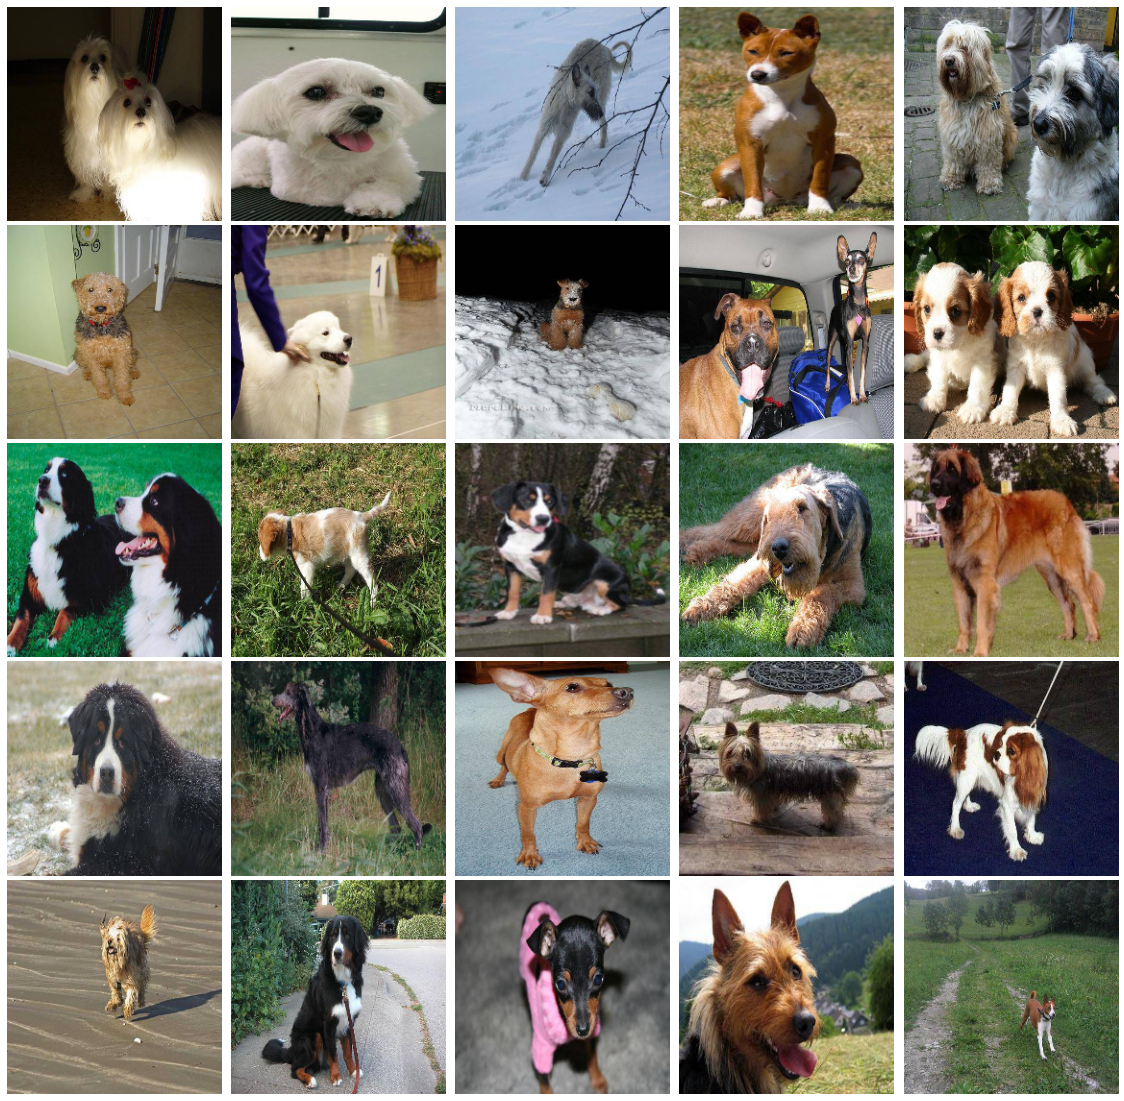

In [11]:
def transform_image(image_filepath):
    img = cv2.imread(image_filepath)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb_resized = cv2.resize(img_rgb, (224, 224))
    return img_rgb_resized

filepaths = [os.path.join(image, fname + ".jpg") for fname in labels["id"]]
resized_images = []

for filepath in filepaths:
    resized_img = transform_image(filepath)
    resized_images.append(resized_img)
resized_images_array = np.array(resized_images)



plt.figure(figsize=(20, 20))

num_images = len(resized_images_array)
rows = 5
cols = 5
total_plots = rows * cols

for i in range(len(resized_images_array)):
    plt.subplot(rows, cols, (i % (rows * cols)) + 1)
    plt.imshow(resized_images_array[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.02, hspace=0.02)  # Boşlukları ayarla
plt.show()

In [14]:
from keras.utils import to_categorical
label_encoder = LabelEncoder()
breed_labelencoded = label_encoder.fit_transform(labels["breed"])
X = np.array(resized_images)
y = to_categorical(breed_labelencoded)


In [15]:
# X ve y'nin boyutlarını kontrol et
print(X.shape)  # Örnek sayısını görüntüle
print(len(y))    # Örnek sayısını görüntüle


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

(2184, 224, 224, 3)
2184


# Augmentation / Model performansını artırmak için

In [16]:
X_train.shape

(1747, 224, 224, 3)

In [17]:
X_val.shape

(437, 224, 224, 3)

In [18]:
y_train.shape

(1747, 20)

In [19]:
y_val.shape

(437, 20)

In [20]:

def random_crop_and_rotate(img):
    # Rastgele kırpma
    height, width, _ = img.shape
    crop_height, crop_width = int(height * 0.9), int(width * 0.9)
    start_height = np.random.randint(0, height - crop_height + 1)
    start_width = np.random.randint(0, width - crop_width + 1)
    cropped_img = img[start_height:start_height+crop_height, start_width:start_width+crop_width, :]

    # Rastgele döndürme
    angle = np.random.uniform(-30, 30)  # Örnek bir döndürme açısı aralığı
    #rotated_img = rotate(cropped_img, angle, mode='nearest')
    rotated_img = rotate(cropped_img, angle, mode='reflect')
    
    # Boyut kontrolü ve yeniden boyutlandırma
    if rotated_img.shape[0] != 224 or rotated_img.shape[1] != 224:
        rotated_img = cv2.resize(rotated_img, (224, 224))

    return rotated_img

#X_train = X_train.reshape(X_train.shape[0], 224, 224, 3)
#X_val = X_val.reshape(X_val.shape[0], 224, 224, 3)

X_train_processed = np.array([random_crop_and_rotate(img) for img in X_train])
#y_train_one_hot = to_categorical(y_train, num_classes=120)
y_train_one_hot = to_categorical(y_train, num_classes=120)

 # ImageDataGenerator tanımlama
train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=random_crop_and_rotate
)

# Eğitim veri setini uygun hale getirme
#train_datagen.fit(X_train)

# Eğitim veri setini oluşturma
training_set = train_datagen.flow(X_train_processed, y=y_train_one_hot, batch_size=128)


# Test veri setini oluşturma (sadece rescale uygulanıyor)
test_datagen = ImageDataGenerator(rescale=1./255)
testing_set = test_datagen.flow(X_val, y=y_val, batch_size=128)


# Model Oluşturma

In [21]:
num_classes = 120

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
#model.add(Dense(num_classes, activation=None))




model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])




In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [23]:
output_neurons = model.layers[-1].output_shape[1]
print("Output neurons:", output_neurons)

Output neurons: 120


In [24]:
epochs=10
#history=model.fit_generator(training_set,validation_data = testing_set,epochs = 10)
history = model.fit(training_set, validation_data=testing_set, epochs=epochs)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/remove_squeezable_dimensions/Squeeze' defined at (most recent call last):
    File "/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/opt/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/anaconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/opt/anaconda3/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/opt/anaconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/opt/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/c1/3699f_zx12s2310fbfzmg__m0000gn/T/ipykernel_52496/3294529125.py", line 3, in <cell line: 3>
      history = model.fit(training_set, validation_data=testing_set, epochs=epochs)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1024, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1082, in compute_loss
      return self.compiled_loss(
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 277, in call
      y_pred, y_true = losses_utils.squeeze_or_expand_dimensions(
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/utils/losses_utils.py", line 200, in squeeze_or_expand_dimensions
      y_true, y_pred = remove_squeezable_dimensions(y_true, y_pred)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/utils/losses_utils.py", line 139, in remove_squeezable_dimensions
      labels = tf.squeeze(labels, [-1])
Node: 'categorical_crossentropy/remove_squeezable_dimensions/Squeeze'
Can not squeeze dim[2], expected a dimension of 1, got 120
	 [[{{node categorical_crossentropy/remove_squeezable_dimensions/Squeeze}}]] [Op:__inference_train_function_1533]

In [ ]:
# Eğitim sırasında kullanılan etiket ve tahminleri yazdırma
for epoch in range(epochs):
    for batch in training_set:
        inputs, targets = batch
        predictions = model.predict(inputs)
        print("Labels shape:", targets.shape)
        print("Predictions shape:", predictions.shape)
        break
    break